In [1]:
import sys
!{sys.executable} -m pip install -r ./requirements.txt


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import boto3
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tf2onnx
import onnx
import yfinance as yfin
import time
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from minio import Minio
import os

2024-03-20 10:14:53.054950: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 10:14:53.084599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-20 10:14:53.084645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-20 10:14:53.085738: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-20 10:14:53.090974: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-20 10:14:53.092005: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
ticker = os.environ.get('TICKER')

In [3]:
df = yfin.download(tickers=['AAPL'], period='6mo')
dataset = df['Close'].fillna(method='ffill')
dataset = dataset.values.reshape(-1, 1)

[*********************100%%**********************]  1 of 1 completed


In [4]:
dataset.shape

(125, 1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(dataset)
dataset = scaler.transform(dataset)

In [6]:
# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

X = []
Y = []

for i in range(n_lookback, len(dataset) - n_forecast + 1):
    X.append(dataset[i - n_lookback: i])
    Y.append(dataset[i: i + n_forecast])

In [7]:
X = np.array(X)
Y = np.array(Y)


In [8]:
# fit the model
model = Sequential(name="forecast")
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

In [9]:

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=32, verbose=0)

In [10]:
# generate the forecasts
X_ = dataset[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 0s 446ms/step


In [11]:
# organize the results in a data frame
df_past = df[['Close']].reset_index()
df_past.rename(columns={'index': 'Date', 'Close': 'Actual'}, inplace=True)
df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

/tmp/ipykernel_9171/3704570742.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


In [12]:

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

<AxesSubplot: title={'center': 'IBM'}, xlabel='Date'>

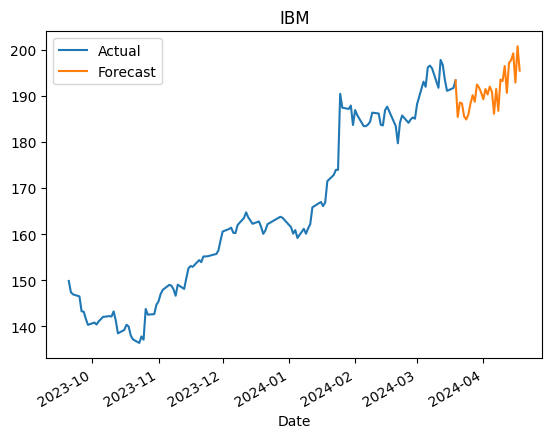

In [13]:
results = pd.concat([df_past, df_future])
results = results.set_index('Date')

# plot the results
results.plot(title='IBM')


In [14]:
import os
model.save("./forecast.keras")

In [15]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, "./forecast.onnx")

2024-03-20 09:44:16.858017: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-20 09:44:16.858135: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-03-20 09:44:16.958988: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-03-20 09:44:16.959103: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-03-20 09:44:17.038688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [7]:
client = Minio(
    "minio.stock-predict.svc.cluster.local:9000",
    access_key="minioadmin",
    secret_key="minioadmin",
    secure=False
)


In [8]:
buckets = client.list_buckets()
for bucket in buckets:
    print(bucket.name, bucket.creation_date)

data 2024-03-19 10:32:37.003000+00:00
models 2024-03-19 10:32:36.981000+00:00
pipeline-artifacts 2024-03-19 10:32:36.975000+00:00


In [ ]:
bucket_name = "models"
source_file = "./forecast.onnx"
destination_file = "forecast.onnx"
client.fput_object(bucket_name, destination_file, source_file)